<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:09:15] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


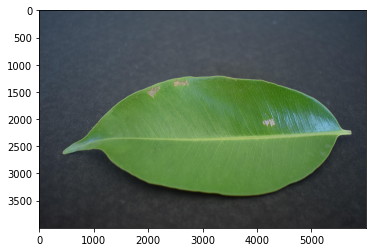

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

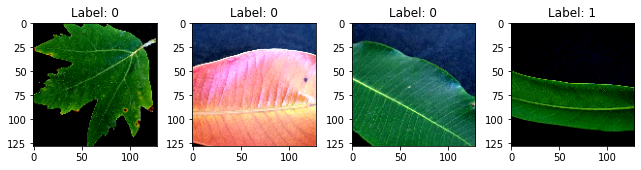

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:09:21] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:09:23] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2520705690933378 samples/sec                   batch loss = 1.550782561302185 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.227839940679196 samples/sec                   batch loss = 0.6871616840362549 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.262012907614879 samples/sec                   batch loss = 0.3287670314311981 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2659079465806853 samples/sec                   batch loss = 0.6645486354827881 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.2609450795853763 samples/sec                   batch loss = 0.7443526983261108 | accuracy = 0.48


Epoch[1] Batch[30] Speed: 1.2591560828343968 samples/sec                   batch loss = 0.4612613022327423 | accuracy = 0.5


Epoch[1] Batch[35] Speed: 1.2639470470487815 samples/sec                   batch loss = 0.7135105729103088 | accuracy = 0.5142857142857142


Epoch[1] Batch[40] Speed: 1.2606927566668125 samples/sec                   batch loss = 0.3534853756427765 | accuracy = 0.53125


Epoch[1] Batch[45] Speed: 1.2639281933495194 samples/sec                   batch loss = 0.8251875042915344 | accuracy = 0.5388888888888889


Epoch[1] Batch[50] Speed: 1.2644623134862965 samples/sec                   batch loss = 0.6973599195480347 | accuracy = 0.545


Epoch[1] Batch[55] Speed: 1.2687182881227657 samples/sec                   batch loss = 0.49729907512664795 | accuracy = 0.5681818181818182


Epoch[1] Batch[60] Speed: 1.2642493543572146 samples/sec                   batch loss = 0.5271632671356201 | accuracy = 0.5666666666666667


Epoch[1] Batch[65] Speed: 1.2669101481013016 samples/sec                   batch loss = 0.6007375121116638 | accuracy = 0.5653846153846154


Epoch[1] Batch[70] Speed: 1.2589503864223308 samples/sec                   batch loss = 0.42443135380744934 | accuracy = 0.5785714285714286


Epoch[1] Batch[75] Speed: 1.2675015634861504 samples/sec                   batch loss = 0.4127304255962372 | accuracy = 0.59


Epoch[1] Batch[80] Speed: 1.2621742158664022 samples/sec                   batch loss = 0.49959835410118103 | accuracy = 0.603125


Epoch[1] Batch[85] Speed: 1.2645089167947716 samples/sec                   batch loss = 1.1470447778701782 | accuracy = 0.6088235294117647


Epoch[1] Batch[90] Speed: 1.2626107808729836 samples/sec                   batch loss = 0.47441571950912476 | accuracy = 0.6222222222222222


Epoch[1] Batch[95] Speed: 1.260969151711719 samples/sec                   batch loss = 0.9471834897994995 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.2658876971288933 samples/sec                   batch loss = 0.4681594967842102 | accuracy = 0.62


Epoch[1] Batch[105] Speed: 1.2683217862627483 samples/sec                   batch loss = 1.1135191917419434 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.260765041645591 samples/sec                   batch loss = 0.5570573806762695 | accuracy = 0.6204545454545455


Epoch[1] Batch[115] Speed: 1.2609317171087975 samples/sec                   batch loss = 0.5980643630027771 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.2602393409852621 samples/sec                   batch loss = 0.5075725317001343 | accuracy = 0.6333333333333333


Epoch[1] Batch[125] Speed: 1.2615959189698436 samples/sec                   batch loss = 0.5778882503509521 | accuracy = 0.64


Epoch[1] Batch[130] Speed: 1.2679482425006516 samples/sec                   batch loss = 0.6153871417045593 | accuracy = 0.6461538461538462


Epoch[1] Batch[135] Speed: 1.263527732747405 samples/sec                   batch loss = 0.26377367973327637 | accuracy = 0.6444444444444445


Epoch[1] Batch[140] Speed: 1.2625087366857726 samples/sec                   batch loss = 0.4741640090942383 | accuracy = 0.6464285714285715


Epoch[1] Batch[145] Speed: 1.2603220830045536 samples/sec                   batch loss = 0.48628106713294983 | accuracy = 0.6448275862068965


Epoch[1] Batch[150] Speed: 1.2620066422051501 samples/sec                   batch loss = 1.0537678003311157 | accuracy = 0.645


Epoch[1] Batch[155] Speed: 1.2638162253925487 samples/sec                   batch loss = 0.3312317728996277 | accuracy = 0.6451612903225806


Epoch[1] Batch[160] Speed: 1.2628630166930321 samples/sec                   batch loss = 0.4135048985481262 | accuracy = 0.6484375


Epoch[1] Batch[165] Speed: 1.266702675783406 samples/sec                   batch loss = 0.3640236258506775 | accuracy = 0.6530303030303031


Epoch[1] Batch[170] Speed: 1.2615423207147138 samples/sec                   batch loss = 0.7782328128814697 | accuracy = 0.6529411764705882


Epoch[1] Batch[175] Speed: 1.2583921230482684 samples/sec                   batch loss = 0.6121621131896973 | accuracy = 0.6514285714285715


Epoch[1] Batch[180] Speed: 1.2598402680976462 samples/sec                   batch loss = 0.6456824541091919 | accuracy = 0.6486111111111111


Epoch[1] Batch[185] Speed: 1.26808145457206 samples/sec                   batch loss = 0.6575726270675659 | accuracy = 0.6527027027027027


Epoch[1] Batch[190] Speed: 1.2668732209011984 samples/sec                   batch loss = 0.4781871736049652 | accuracy = 0.6526315789473685


Epoch[1] Batch[195] Speed: 1.266375965781342 samples/sec                   batch loss = 0.5834982395172119 | accuracy = 0.6525641025641026


Epoch[1] Batch[200] Speed: 1.2646569455848724 samples/sec                   batch loss = 0.34731459617614746 | accuracy = 0.655


Epoch[1] Batch[205] Speed: 1.2646777276739238 samples/sec                   batch loss = 0.9812300801277161 | accuracy = 0.6548780487804878


Epoch[1] Batch[210] Speed: 1.2664202247808458 samples/sec                   batch loss = 0.3111245036125183 | accuracy = 0.6595238095238095


Epoch[1] Batch[215] Speed: 1.267599915046135 samples/sec                   batch loss = 0.4590001106262207 | accuracy = 0.6627906976744186


Epoch[1] Batch[220] Speed: 1.2640754195083572 samples/sec                   batch loss = 0.3656163811683655 | accuracy = 0.6636363636363637


Epoch[1] Batch[225] Speed: 1.260969151711719 samples/sec                   batch loss = 0.6909346580505371 | accuracy = 0.6655555555555556


Epoch[1] Batch[230] Speed: 1.259560774282438 samples/sec                   batch loss = 0.7113745212554932 | accuracy = 0.6673913043478261


Epoch[1] Batch[235] Speed: 1.2605706584073315 samples/sec                   batch loss = 0.25672221183776855 | accuracy = 0.6680851063829787


Epoch[1] Batch[240] Speed: 1.257693575455283 samples/sec                   batch loss = 0.692539393901825 | accuracy = 0.6645833333333333


Epoch[1] Batch[245] Speed: 1.262783077253676 samples/sec                   batch loss = 0.6644854545593262 | accuracy = 0.6653061224489796


Epoch[1] Batch[250] Speed: 1.2647600047583372 samples/sec                   batch loss = 0.23659832775592804 | accuracy = 0.669


Epoch[1] Batch[255] Speed: 1.2702633046197103 samples/sec                   batch loss = 0.47210654616355896 | accuracy = 0.6676470588235294


Epoch[1] Batch[260] Speed: 1.2667520267997998 samples/sec                   batch loss = 0.45712417364120483 | accuracy = 0.6682692307692307


Epoch[1] Batch[265] Speed: 1.2621789636438157 samples/sec                   batch loss = 0.275407075881958 | accuracy = 0.6698113207547169


Epoch[1] Batch[270] Speed: 1.2596116508936317 samples/sec                   batch loss = 0.35839220881462097 | accuracy = 0.6722222222222223


Epoch[1] Batch[275] Speed: 1.2660397748852243 samples/sec                   batch loss = 0.4402320683002472 | accuracy = 0.6754545454545454


Epoch[1] Batch[280] Speed: 1.2659843654415242 samples/sec                   batch loss = 0.7157599925994873 | accuracy = 0.6741071428571429


Epoch[1] Batch[285] Speed: 1.265079394642759 samples/sec                   batch loss = 0.6506819725036621 | accuracy = 0.6763157894736842


Epoch[1] Batch[290] Speed: 1.264087801020359 samples/sec                   batch loss = 0.5505965948104858 | accuracy = 0.6793103448275862


Epoch[1] Batch[295] Speed: 1.2735503389018277 samples/sec                   batch loss = 0.3342449963092804 | accuracy = 0.6822033898305084


Epoch[1] Batch[300] Speed: 1.2627338449182297 samples/sec                   batch loss = 0.7021543979644775 | accuracy = 0.6783333333333333


Epoch[1] Batch[305] Speed: 1.261227748096587 samples/sec                   batch loss = 0.7121416926383972 | accuracy = 0.6786885245901639


Epoch[1] Batch[310] Speed: 1.2636851452661828 samples/sec                   batch loss = 0.5846312642097473 | accuracy = 0.6790322580645162


Epoch[1] Batch[315] Speed: 1.265650387460408 samples/sec                   batch loss = 0.586952805519104 | accuracy = 0.676984126984127


Epoch[1] Batch[320] Speed: 1.263279226443632 samples/sec                   batch loss = 0.20424014329910278 | accuracy = 0.67734375


Epoch[1] Batch[325] Speed: 1.2626919339281264 samples/sec                   batch loss = 0.42699095606803894 | accuracy = 0.6776923076923077


Epoch[1] Batch[330] Speed: 1.2591893482823961 samples/sec                   batch loss = 0.5640886425971985 | accuracy = 0.6765151515151515


Epoch[1] Batch[335] Speed: 1.2626958302974307 samples/sec                   batch loss = 0.20199596881866455 | accuracy = 0.6791044776119403


Epoch[1] Batch[340] Speed: 1.265174603837735 samples/sec                   batch loss = 0.4432472288608551 | accuracy = 0.6786764705882353


Epoch[1] Batch[345] Speed: 1.2665603827549496 samples/sec                   batch loss = 1.2192949056625366 | accuracy = 0.6768115942028986


Epoch[1] Batch[350] Speed: 1.2616617609358842 samples/sec                   batch loss = 0.6337595582008362 | accuracy = 0.6735714285714286


Epoch[1] Batch[355] Speed: 1.2642843185623893 samples/sec                   batch loss = 0.33645790815353394 | accuracy = 0.6753521126760563


Epoch[1] Batch[360] Speed: 1.2642934648316249 samples/sec                   batch loss = 0.8842447996139526 | accuracy = 0.6729166666666667


Epoch[1] Batch[365] Speed: 1.2621063265565733 samples/sec                   batch loss = 0.6058558225631714 | accuracy = 0.6719178082191781


Epoch[1] Batch[370] Speed: 1.2600351831961822 samples/sec                   batch loss = 0.6934107542037964 | accuracy = 0.672972972972973


Epoch[1] Batch[375] Speed: 1.26006982005275 samples/sec                   batch loss = 0.5690797567367554 | accuracy = 0.674


Epoch[1] Batch[380] Speed: 1.2653288006229648 samples/sec                   batch loss = 0.47391876578330994 | accuracy = 0.6736842105263158


Epoch[1] Batch[385] Speed: 1.27112273915885 samples/sec                   batch loss = 0.3482871353626251 | accuracy = 0.6733766233766234


Epoch[1] Batch[390] Speed: 1.2732224064830675 samples/sec                   batch loss = 0.33295586705207825 | accuracy = 0.6730769230769231


Epoch[1] Batch[395] Speed: 1.2602527834574515 samples/sec                   batch loss = 0.14529849588871002 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.2638124173074912 samples/sec                   batch loss = 0.2752131521701813 | accuracy = 0.67625


Epoch[1] Batch[405] Speed: 1.268539093063312 samples/sec                   batch loss = 0.7967123985290527 | accuracy = 0.6765432098765433


Epoch[1] Batch[410] Speed: 1.257123615014465 samples/sec                   batch loss = 0.4048699140548706 | accuracy = 0.6786585365853659


Epoch[1] Batch[415] Speed: 1.2579665817235863 samples/sec                   batch loss = 0.1743154525756836 | accuracy = 0.6819277108433734


Epoch[1] Batch[420] Speed: 1.261896627950549 samples/sec                   batch loss = 0.6456418633460999 | accuracy = 0.6833333333333333


Epoch[1] Batch[425] Speed: 1.259264201967255 samples/sec                   batch loss = 0.34507814049720764 | accuracy = 0.6835294117647058


Epoch[1] Batch[430] Speed: 1.2603047574032842 samples/sec                   batch loss = 0.4226793944835663 | accuracy = 0.6848837209302325


Epoch[1] Batch[435] Speed: 1.265847200168707 samples/sec                   batch loss = 0.19391272962093353 | accuracy = 0.6862068965517242


Epoch[1] Batch[440] Speed: 1.2584323331861669 samples/sec                   batch loss = 0.4328268766403198 | accuracy = 0.6863636363636364


Epoch[1] Batch[445] Speed: 1.2622748763961624 samples/sec                   batch loss = 0.5479809641838074 | accuracy = 0.6865168539325842


Epoch[1] Batch[450] Speed: 1.2637713866467704 samples/sec                   batch loss = 0.3008583188056946 | accuracy = 0.6877777777777778


Epoch[1] Batch[455] Speed: 1.2663095352929516 samples/sec                   batch loss = 1.1950074434280396 | accuracy = 0.6879120879120879


Epoch[1] Batch[460] Speed: 1.2592536160574124 samples/sec                   batch loss = 0.8918635845184326 | accuracy = 0.6875


Epoch[1] Batch[465] Speed: 1.2585712006278598 samples/sec                   batch loss = 0.6614392399787903 | accuracy = 0.689247311827957


Epoch[1] Batch[470] Speed: 1.2616539809795533 samples/sec                   batch loss = 0.5755459666252136 | accuracy = 0.6877659574468085


Epoch[1] Batch[475] Speed: 1.267782772673312 samples/sec                   batch loss = 0.9141454696655273 | accuracy = 0.6868421052631579


Epoch[1] Batch[480] Speed: 1.265801357680287 samples/sec                   batch loss = 0.540640652179718 | accuracy = 0.6854166666666667


Epoch[1] Batch[485] Speed: 1.2601688200376355 samples/sec                   batch loss = 0.635787308216095 | accuracy = 0.6850515463917526


Epoch[1] Batch[490] Speed: 1.2634687369504307 samples/sec                   batch loss = 0.37604424357414246 | accuracy = 0.6857142857142857


Epoch[1] Batch[495] Speed: 1.2554699080226914 samples/sec                   batch loss = 0.41951340436935425 | accuracy = 0.6853535353535354


Epoch[1] Batch[500] Speed: 1.2615210724016699 samples/sec                   batch loss = 0.5644192695617676 | accuracy = 0.6845


Epoch[1] Batch[505] Speed: 1.2651051512273972 samples/sec                   batch loss = 0.17005576193332672 | accuracy = 0.6851485148514852


Epoch[1] Batch[510] Speed: 1.2586933840035237 samples/sec                   batch loss = 0.37203988432884216 | accuracy = 0.6838235294117647


Epoch[1] Batch[515] Speed: 1.2540012304406318 samples/sec                   batch loss = 0.1549336463212967 | accuracy = 0.6854368932038835


Epoch[1] Batch[520] Speed: 1.2557657295413194 samples/sec                   batch loss = 0.2971208691596985 | accuracy = 0.6850961538461539


Epoch[1] Batch[525] Speed: 1.2535207700195943 samples/sec                   batch loss = 0.36845695972442627 | accuracy = 0.6852380952380952


Epoch[1] Batch[530] Speed: 1.254128715440236 samples/sec                   batch loss = 0.3136961758136749 | accuracy = 0.6863207547169812


Epoch[1] Batch[535] Speed: 1.2625724886159602 samples/sec                   batch loss = 0.4723663330078125 | accuracy = 0.6864485981308411


Epoch[1] Batch[540] Speed: 1.2535700358701567 samples/sec                   batch loss = 0.2214547097682953 | accuracy = 0.687037037037037


Epoch[1] Batch[545] Speed: 1.2556246612974191 samples/sec                   batch loss = 0.5928012132644653 | accuracy = 0.6871559633027523


Epoch[1] Batch[550] Speed: 1.262635391763015 samples/sec                   batch loss = 0.2874939441680908 | accuracy = 0.6886363636363636


Epoch[1] Batch[555] Speed: 1.2666537111335896 samples/sec                   batch loss = 0.45591437816619873 | accuracy = 0.6887387387387387


Epoch[1] Batch[560] Speed: 1.264988396442576 samples/sec                   batch loss = 0.39865642786026 | accuracy = 0.6888392857142858


Epoch[1] Batch[565] Speed: 1.2583474795910248 samples/sec                   batch loss = 0.648226797580719 | accuracy = 0.6889380530973451


Epoch[1] Batch[570] Speed: 1.2598442414925939 samples/sec                   batch loss = 0.5436450242996216 | accuracy = 0.6885964912280702


Epoch[1] Batch[575] Speed: 1.262544079732579 samples/sec                   batch loss = 0.4040002226829529 | accuracy = 0.688695652173913


Epoch[1] Batch[580] Speed: 1.2613190594682064 samples/sec                   batch loss = 0.6600112318992615 | accuracy = 0.6866379310344828


Epoch[1] Batch[585] Speed: 1.2597972245921387 samples/sec                   batch loss = 0.18018093705177307 | accuracy = 0.6884615384615385


Epoch[1] Batch[590] Speed: 1.2671273542136898 samples/sec                   batch loss = 0.563718855381012 | accuracy = 0.6885593220338984


Epoch[1] Batch[595] Speed: 1.2601239557843917 samples/sec                   batch loss = 0.3896093964576721 | accuracy = 0.6899159663865546


Epoch[1] Batch[600] Speed: 1.2650921774092299 samples/sec                   batch loss = 0.6200442314147949 | accuracy = 0.69


Epoch[1] Batch[605] Speed: 1.2623313862766323 samples/sec                   batch loss = 0.5979799628257751 | accuracy = 0.6909090909090909


Epoch[1] Batch[610] Speed: 1.2634136474629563 samples/sec                   batch loss = 0.8544082045555115 | accuracy = 0.6905737704918032


Epoch[1] Batch[615] Speed: 1.2690714543763453 samples/sec                   batch loss = 0.8985826373100281 | accuracy = 0.6906504065040651


Epoch[1] Batch[620] Speed: 1.2718004230688906 samples/sec                   batch loss = 0.8212995529174805 | accuracy = 0.6887096774193548


Epoch[1] Batch[625] Speed: 1.2645871685212375 samples/sec                   batch loss = 0.3488953113555908 | accuracy = 0.6896


Epoch[1] Batch[630] Speed: 1.266210332662538 samples/sec                   batch loss = 0.6007431745529175 | accuracy = 0.6888888888888889


Epoch[1] Batch[635] Speed: 1.2626116360615665 samples/sec                   batch loss = 0.35550153255462646 | accuracy = 0.6905511811023622


Epoch[1] Batch[640] Speed: 1.2646575175598342 samples/sec                   batch loss = 0.3011326789855957 | accuracy = 0.691015625


Epoch[1] Batch[645] Speed: 1.2659246624181484 samples/sec                   batch loss = 0.3380163609981537 | accuracy = 0.6914728682170542


Epoch[1] Batch[650] Speed: 1.2633297379940416 samples/sec                   batch loss = 0.4592176079750061 | accuracy = 0.691923076923077


Epoch[1] Batch[655] Speed: 1.2655485196244998 samples/sec                   batch loss = 0.49895867705345154 | accuracy = 0.6923664122137405


Epoch[1] Batch[660] Speed: 1.2556000410420336 samples/sec                   batch loss = 0.49519822001457214 | accuracy = 0.6924242424242424


Epoch[1] Batch[665] Speed: 1.2592291368225623 samples/sec                   batch loss = 0.5888732671737671 | accuracy = 0.6928571428571428


Epoch[1] Batch[670] Speed: 1.2600489052203372 samples/sec                   batch loss = 0.6892036199569702 | accuracy = 0.6932835820895522


Epoch[1] Batch[675] Speed: 1.2542805126328054 samples/sec                   batch loss = 0.699108898639679 | accuracy = 0.692962962962963


Epoch[1] Batch[680] Speed: 1.2560846361197284 samples/sec                   batch loss = 0.7074671983718872 | accuracy = 0.6933823529411764


Epoch[1] Batch[685] Speed: 1.2609776814258358 samples/sec                   batch loss = 0.36765256524086 | accuracy = 0.6941605839416058


Epoch[1] Batch[690] Speed: 1.2626045095254408 samples/sec                   batch loss = 1.779775857925415 | accuracy = 0.6949275362318841


Epoch[1] Batch[695] Speed: 1.257173447088194 samples/sec                   batch loss = 0.5073553919792175 | accuracy = 0.6946043165467626


Epoch[1] Batch[700] Speed: 1.264237731807215 samples/sec                   batch loss = 0.42919158935546875 | accuracy = 0.695


Epoch[1] Batch[705] Speed: 1.2667048754561328 samples/sec                   batch loss = 0.3074672222137451 | accuracy = 0.6968085106382979


Epoch[1] Batch[710] Speed: 1.2600895998769444 samples/sec                   batch loss = 0.816032886505127 | accuracy = 0.6957746478873239


Epoch[1] Batch[715] Speed: 1.2611827136074878 samples/sec                   batch loss = 0.38577502965927124 | accuracy = 0.6961538461538461


Epoch[1] Batch[720] Speed: 1.258430256543348 samples/sec                   batch loss = 0.23289568722248077 | accuracy = 0.6961805555555556


Epoch[1] Batch[725] Speed: 1.2684734904021562 samples/sec                   batch loss = 0.813775897026062 | accuracy = 0.6972413793103448


Epoch[1] Batch[730] Speed: 1.2607114192292799 samples/sec                   batch loss = 0.4025532603263855 | accuracy = 0.696917808219178


Epoch[1] Batch[735] Speed: 1.2614093408200402 samples/sec                   batch loss = 1.2288081645965576 | accuracy = 0.6972789115646258


Epoch[1] Batch[740] Speed: 1.271312394723284 samples/sec                   batch loss = 0.35833218693733215 | accuracy = 0.6969594594594595


Epoch[1] Batch[745] Speed: 1.2637486352940857 samples/sec                   batch loss = 0.28146296739578247 | accuracy = 0.6963087248322147


Epoch[1] Batch[750] Speed: 1.2657589563345566 samples/sec                   batch loss = 0.50423663854599 | accuracy = 0.697


Epoch[1] Batch[755] Speed: 1.265351418039665 samples/sec                   batch loss = 0.6822832822799683 | accuracy = 0.6956953642384106


Epoch[1] Batch[760] Speed: 1.261814533175623 samples/sec                   batch loss = 0.7133845090866089 | accuracy = 0.6957236842105263


Epoch[1] Batch[765] Speed: 1.2714670314063545 samples/sec                   batch loss = 0.5232640504837036 | accuracy = 0.6964052287581699


Epoch[1] Batch[770] Speed: 1.2674502390348494 samples/sec                   batch loss = 0.2892974019050598 | accuracy = 0.6970779220779221


Epoch[1] Batch[775] Speed: 1.2628943868955147 samples/sec                   batch loss = 0.24494880437850952 | accuracy = 0.6980645161290323


Epoch[1] Batch[780] Speed: 1.2577002695283621 samples/sec                   batch loss = 0.46429958939552307 | accuracy = 0.6983974358974359


Epoch[1] Batch[785] Speed: 1.2614617895985216 samples/sec                   batch loss = 0.3998439908027649 | accuracy = 0.6984076433121019


[Epoch 1] training: accuracy=0.6986040609137056
[Epoch 1] time cost: 646.8853664398193
[Epoch 1] validation: validation accuracy=0.7388888888888889


Epoch[2] Batch[5] Speed: 1.2674452600182187 samples/sec                   batch loss = 0.28412145376205444 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2653030349309493 samples/sec                   batch loss = 0.2834719717502594 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.272129552484886 samples/sec                   batch loss = 0.4969561994075775 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.2704860877619923 samples/sec                   batch loss = 0.46665626764297485 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2674708257688603 samples/sec                   batch loss = 0.4991722106933594 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.269423184467127 samples/sec                   batch loss = 0.6468888521194458 | accuracy = 0.7083333333333334


Epoch[2] Batch[35] Speed: 1.2697051509693817 samples/sec                   batch loss = 0.8395388722419739 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2595885762335206 samples/sec                   batch loss = 0.5353178977966309 | accuracy = 0.7125


Epoch[2] Batch[45] Speed: 1.2666968419057816 samples/sec                   batch loss = 0.14811263978481293 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2609982479888702 samples/sec                   batch loss = 0.4587990343570709 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.2616553092579883 samples/sec                   batch loss = 0.7627245783805847 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.265735464919994 samples/sec                   batch loss = 0.1853453814983368 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.2644609792908272 samples/sec                   batch loss = 0.9568682312965393 | accuracy = 0.7230769230769231


Epoch[2] Batch[70] Speed: 1.2634858641949043 samples/sec                   batch loss = 0.4100584387779236 | accuracy = 0.725


Epoch[2] Batch[75] Speed: 1.2640167534874343 samples/sec                   batch loss = 1.0604047775268555 | accuracy = 0.7133333333333334


Epoch[2] Batch[80] Speed: 1.265455640380798 samples/sec                   batch loss = 0.29839804768562317 | accuracy = 0.7125


Epoch[2] Batch[85] Speed: 1.2669987438923056 samples/sec                   batch loss = 0.1365704983472824 | accuracy = 0.7058823529411765


Epoch[2] Batch[90] Speed: 1.270490513434524 samples/sec                   batch loss = 0.7343224287033081 | accuracy = 0.7083333333333334


Epoch[2] Batch[95] Speed: 1.2733578888807087 samples/sec                   batch loss = 0.5049819350242615 | accuracy = 0.7131578947368421


Epoch[2] Batch[100] Speed: 1.2672218190475557 samples/sec                   batch loss = 1.2043156623840332 | accuracy = 0.7075


Epoch[2] Batch[105] Speed: 1.2738096729478638 samples/sec                   batch loss = 0.2656898498535156 | accuracy = 0.7142857142857143


Epoch[2] Batch[110] Speed: 1.2732510080691064 samples/sec                   batch loss = 0.41598474979400635 | accuracy = 0.7227272727272728


Epoch[2] Batch[115] Speed: 1.2775062351583282 samples/sec                   batch loss = 0.8949753046035767 | accuracy = 0.7239130434782609


Epoch[2] Batch[120] Speed: 1.2771341651865793 samples/sec                   batch loss = 0.35725170373916626 | accuracy = 0.73125


Epoch[2] Batch[125] Speed: 1.275770176349364 samples/sec                   batch loss = 0.3145086467266083 | accuracy = 0.732


Epoch[2] Batch[130] Speed: 1.2708137670905664 samples/sec                   batch loss = 0.3648996651172638 | accuracy = 0.7307692307692307


Epoch[2] Batch[135] Speed: 1.267804424056795 samples/sec                   batch loss = 0.24292966723442078 | accuracy = 0.737037037037037


Epoch[2] Batch[140] Speed: 1.2758159676080603 samples/sec                   batch loss = 0.3071289658546448 | accuracy = 0.7392857142857143


Epoch[2] Batch[145] Speed: 1.2731170941523875 samples/sec                   batch loss = 0.6948285102844238 | accuracy = 0.7362068965517241


Epoch[2] Batch[150] Speed: 1.274332239362649 samples/sec                   batch loss = 0.6535677909851074 | accuracy = 0.735


Epoch[2] Batch[155] Speed: 1.2768295521085415 samples/sec                   batch loss = 0.3374549150466919 | accuracy = 0.7419354838709677


Epoch[2] Batch[160] Speed: 1.2697342674214993 samples/sec                   batch loss = 0.636981725692749 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.2667376801776566 samples/sec                   batch loss = 0.2814007103443146 | accuracy = 0.7424242424242424


Epoch[2] Batch[170] Speed: 1.2713567104256198 samples/sec                   batch loss = 1.112990379333496 | accuracy = 0.7426470588235294


Epoch[2] Batch[175] Speed: 1.27225361086512 samples/sec                   batch loss = 0.5062695741653442 | accuracy = 0.7442857142857143


Epoch[2] Batch[180] Speed: 1.2690022451754597 samples/sec                   batch loss = 0.5085741281509399 | accuracy = 0.7430555555555556


Epoch[2] Batch[185] Speed: 1.2747598221422558 samples/sec                   batch loss = 0.4584988057613373 | accuracy = 0.7432432432432432


Epoch[2] Batch[190] Speed: 1.275775706051435 samples/sec                   batch loss = 0.7977734804153442 | accuracy = 0.7394736842105263


Epoch[2] Batch[195] Speed: 1.2710091077838515 samples/sec                   batch loss = 0.3972829282283783 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.2687904408984345 samples/sec                   batch loss = 0.44250938296318054 | accuracy = 0.74


Epoch[2] Batch[205] Speed: 1.272309666949154 samples/sec                   batch loss = 0.2595628499984741 | accuracy = 0.7414634146341463


Epoch[2] Batch[210] Speed: 1.273338076887318 samples/sec                   batch loss = 0.649541974067688 | accuracy = 0.7440476190476191


Epoch[2] Batch[215] Speed: 1.294721590595582 samples/sec                   batch loss = 0.7085111737251282 | accuracy = 0.7418604651162791


Epoch[2] Batch[220] Speed: 1.2950067123045743 samples/sec                   batch loss = 0.43122124671936035 | accuracy = 0.7363636363636363


Epoch[2] Batch[225] Speed: 1.3029545942051923 samples/sec                   batch loss = 0.4593655467033386 | accuracy = 0.7366666666666667


Epoch[2] Batch[230] Speed: 1.2974308616757144 samples/sec                   batch loss = 0.586201548576355 | accuracy = 0.7380434782608696


Epoch[2] Batch[235] Speed: 1.2985491452379534 samples/sec                   batch loss = 0.462104469537735 | accuracy = 0.7393617021276596


Epoch[2] Batch[240] Speed: 1.2963052877479442 samples/sec                   batch loss = 0.36149734258651733 | accuracy = 0.7385416666666667


Epoch[2] Batch[245] Speed: 1.2921887016393416 samples/sec                   batch loss = 1.0214614868164062 | accuracy = 0.7397959183673469


Epoch[2] Batch[250] Speed: 1.2926934902698657 samples/sec                   batch loss = 0.24329881370067596 | accuracy = 0.74


Epoch[2] Batch[255] Speed: 1.2975515748261994 samples/sec                   batch loss = 0.4643113911151886 | accuracy = 0.7411764705882353


Epoch[2] Batch[260] Speed: 1.2998175769766123 samples/sec                   batch loss = 0.3754522204399109 | accuracy = 0.7432692307692308


Epoch[2] Batch[265] Speed: 1.2974123001330649 samples/sec                   batch loss = 0.5109648108482361 | accuracy = 0.7452830188679245


Epoch[2] Batch[270] Speed: 1.2968338476310575 samples/sec                   batch loss = 0.38006702065467834 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.2967415315219222 samples/sec                   batch loss = 0.6453760862350464 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2984658301704097 samples/sec                   batch loss = 0.8488921523094177 | accuracy = 0.7482142857142857


Epoch[2] Batch[285] Speed: 1.2975726492500634 samples/sec                   batch loss = 0.7077617049217224 | accuracy = 0.7456140350877193


Epoch[2] Batch[290] Speed: 1.3012768978739984 samples/sec                   batch loss = 0.3958982527256012 | accuracy = 0.7474137931034482


Epoch[2] Batch[295] Speed: 1.2965259779827576 samples/sec                   batch loss = 0.2357378602027893 | accuracy = 0.747457627118644


Epoch[2] Batch[300] Speed: 1.2976503294668331 samples/sec                   batch loss = 0.34736716747283936 | accuracy = 0.75


Epoch[2] Batch[305] Speed: 1.3066316719950468 samples/sec                   batch loss = 0.10620616376399994 | accuracy = 0.7483606557377049


Epoch[2] Batch[310] Speed: 1.2973157886719353 samples/sec                   batch loss = 0.5996875762939453 | accuracy = 0.7483870967741936


Epoch[2] Batch[315] Speed: 1.3006026324441333 samples/sec                   batch loss = 0.18539148569107056 | accuracy = 0.7484126984126984


Epoch[2] Batch[320] Speed: 1.2944728487873491 samples/sec                   batch loss = 0.22582346200942993 | accuracy = 0.75


Epoch[2] Batch[325] Speed: 1.2985742725074538 samples/sec                   batch loss = 0.3950589597225189 | accuracy = 0.7507692307692307


Epoch[2] Batch[330] Speed: 1.295839710622953 samples/sec                   batch loss = 0.568367600440979 | accuracy = 0.7477272727272727


Epoch[2] Batch[335] Speed: 1.2968179093836094 samples/sec                   batch loss = 0.35041502118110657 | accuracy = 0.7485074626865672


Epoch[2] Batch[340] Speed: 1.2997880714971077 samples/sec                   batch loss = 1.1047663688659668 | accuracy = 0.7485294117647059


Epoch[2] Batch[345] Speed: 1.301254088132168 samples/sec                   batch loss = 0.20336274802684784 | accuracy = 0.7492753623188406


Epoch[2] Batch[350] Speed: 1.2961816018441281 samples/sec                   batch loss = 0.8890440464019775 | accuracy = 0.7492857142857143


Epoch[2] Batch[355] Speed: 1.2953055602458339 samples/sec                   batch loss = 0.4670993387699127 | accuracy = 0.7471830985915493


Epoch[2] Batch[360] Speed: 1.291878755771298 samples/sec                   batch loss = 0.8776029944419861 | accuracy = 0.7451388888888889


Epoch[2] Batch[365] Speed: 1.2966129523760357 samples/sec                   batch loss = 0.318496435880661 | accuracy = 0.7458904109589041


Epoch[2] Batch[370] Speed: 1.2957663501604182 samples/sec                   batch loss = 0.6062585115432739 | accuracy = 0.745945945945946


Epoch[2] Batch[375] Speed: 1.2964338058786724 samples/sec                   batch loss = 0.09451106935739517 | accuracy = 0.746


Epoch[2] Batch[380] Speed: 1.3003544480160607 samples/sec                   batch loss = 0.4275692403316498 | accuracy = 0.7467105263157895


Epoch[2] Batch[385] Speed: 1.2959170833844744 samples/sec                   batch loss = 1.1637791395187378 | accuracy = 0.7441558441558441


Epoch[2] Batch[390] Speed: 1.2964644616673924 samples/sec                   batch loss = 0.9974580407142639 | accuracy = 0.7455128205128205


Epoch[2] Batch[395] Speed: 1.2943177582090952 samples/sec                   batch loss = 0.6428565979003906 | accuracy = 0.7443037974683544


Epoch[2] Batch[400] Speed: 1.299675097028944 samples/sec                   batch loss = 0.11972358822822571 | accuracy = 0.74375


Epoch[2] Batch[405] Speed: 1.2975749574428428 samples/sec                   batch loss = 0.2869282364845276 | accuracy = 0.745679012345679


Epoch[2] Batch[410] Speed: 1.3020734187039193 samples/sec                   batch loss = 0.3751046359539032 | accuracy = 0.7451219512195122


Epoch[2] Batch[415] Speed: 1.306646834738056 samples/sec                   batch loss = 0.34022757411003113 | accuracy = 0.7451807228915662


Epoch[2] Batch[420] Speed: 1.299794113465754 samples/sec                   batch loss = 0.6111161112785339 | accuracy = 0.7458333333333333


Epoch[2] Batch[425] Speed: 1.297318196267635 samples/sec                   batch loss = 0.6989092826843262 | accuracy = 0.7470588235294118


Epoch[2] Batch[430] Speed: 1.2947563621248857 samples/sec                   batch loss = 0.4963303208351135 | accuracy = 0.747093023255814


Epoch[2] Batch[435] Speed: 1.295882649863226 samples/sec                   batch loss = 0.5833832025527954 | accuracy = 0.7477011494252873


Epoch[2] Batch[440] Speed: 1.3053541784800853 samples/sec                   batch loss = 0.5494954586029053 | accuracy = 0.7482954545454545


Epoch[2] Batch[445] Speed: 1.303801600895747 samples/sec                   batch loss = 0.28681156039237976 | accuracy = 0.750561797752809


Epoch[2] Batch[450] Speed: 1.2979509009993482 samples/sec                   batch loss = 0.5250833630561829 | accuracy = 0.7488888888888889


Epoch[2] Batch[455] Speed: 1.302025319049137 samples/sec                   batch loss = 0.5527575612068176 | accuracy = 0.7472527472527473


Epoch[2] Batch[460] Speed: 1.3020847367862258 samples/sec                   batch loss = 0.5633441805839539 | accuracy = 0.746195652173913


Epoch[2] Batch[465] Speed: 1.297660868197191 samples/sec                   batch loss = 0.5736658573150635 | accuracy = 0.7462365591397849


Epoch[2] Batch[470] Speed: 1.2991490478088747 samples/sec                   batch loss = 0.2983596622943878 | accuracy = 0.7473404255319149


Epoch[2] Batch[475] Speed: 1.2939670690122054 samples/sec                   batch loss = 0.35709407925605774 | accuracy = 0.748421052631579


Epoch[2] Batch[480] Speed: 1.2940479113200236 samples/sec                   batch loss = 0.3432098627090454 | accuracy = 0.7489583333333333


Epoch[2] Batch[485] Speed: 1.2951090789397302 samples/sec                   batch loss = 0.5360915660858154 | accuracy = 0.7474226804123711


Epoch[2] Batch[490] Speed: 1.2983545925810016 samples/sec                   batch loss = 0.18900160491466522 | accuracy = 0.7494897959183674


Epoch[2] Batch[495] Speed: 1.3047634490511482 samples/sec                   batch loss = 0.39967983961105347 | accuracy = 0.747979797979798


Epoch[2] Batch[500] Speed: 1.2956073476061187 samples/sec                   batch loss = 1.0555588006973267 | accuracy = 0.747


Epoch[2] Batch[505] Speed: 1.294628276240501 samples/sec                   batch loss = 0.1347554326057434 | accuracy = 0.746039603960396


Epoch[2] Batch[510] Speed: 1.3012257284621878 samples/sec                   batch loss = 0.26636865735054016 | accuracy = 0.7480392156862745


Epoch[2] Batch[515] Speed: 1.2952366600139025 samples/sec                   batch loss = 0.49456650018692017 | accuracy = 0.7485436893203884


Epoch[2] Batch[520] Speed: 1.2931256116967282 samples/sec                   batch loss = 0.18203675746917725 | accuracy = 0.7495192307692308


Epoch[2] Batch[525] Speed: 1.2963205122598338 samples/sec                   batch loss = 0.4946034252643585 | accuracy = 0.75


Epoch[2] Batch[530] Speed: 1.297074973942094 samples/sec                   batch loss = 0.2867705821990967 | accuracy = 0.7490566037735849


Epoch[2] Batch[535] Speed: 1.2934324666874308 samples/sec                   batch loss = 0.390713632106781 | accuracy = 0.7485981308411215


Epoch[2] Batch[540] Speed: 1.2956885951370098 samples/sec                   batch loss = 1.2257380485534668 | accuracy = 0.7481481481481481


Epoch[2] Batch[545] Speed: 1.299469235963442 samples/sec                   batch loss = 0.43861404061317444 | accuracy = 0.7486238532110092


Epoch[2] Batch[550] Speed: 1.296690417506216 samples/sec                   batch loss = 0.6659621596336365 | accuracy = 0.7472727272727273


Epoch[2] Batch[555] Speed: 1.2934734515235875 samples/sec                   batch loss = 0.4502788186073303 | accuracy = 0.7486486486486487


Epoch[2] Batch[560] Speed: 1.2960466258686711 samples/sec                   batch loss = 0.5071272850036621 | accuracy = 0.7482142857142857


Epoch[2] Batch[565] Speed: 1.2980493147166197 samples/sec                   batch loss = 0.9770011901855469 | accuracy = 0.7473451327433628


Epoch[2] Batch[570] Speed: 1.29657607701487 samples/sec                   batch loss = 0.40663841366767883 | accuracy = 0.7478070175438597


Epoch[2] Batch[575] Speed: 1.2932170149309645 samples/sec                   batch loss = 0.49694886803627014 | accuracy = 0.7469565217391304


Epoch[2] Batch[580] Speed: 1.3026009291151046 samples/sec                   batch loss = 0.5795501470565796 | accuracy = 0.746551724137931


Epoch[2] Batch[585] Speed: 1.2987546143243118 samples/sec                   batch loss = 0.459953248500824 | accuracy = 0.7457264957264957


Epoch[2] Batch[590] Speed: 1.2994658138856168 samples/sec                   batch loss = 0.5784440040588379 | accuracy = 0.7449152542372881


Epoch[2] Batch[595] Speed: 1.2998552412073212 samples/sec                   batch loss = 0.5443304777145386 | accuracy = 0.7453781512605042


Epoch[2] Batch[600] Speed: 1.2961057995603633 samples/sec                   batch loss = 0.801172137260437 | accuracy = 0.745


Epoch[2] Batch[605] Speed: 1.3028644399312055 samples/sec                   batch loss = 0.38659384846687317 | accuracy = 0.7442148760330578


Epoch[2] Batch[610] Speed: 1.2968028736602375 samples/sec                   batch loss = 1.103192925453186 | accuracy = 0.7446721311475409


Epoch[2] Batch[615] Speed: 1.29860221517307 samples/sec                   batch loss = 1.8768675327301025 | accuracy = 0.7447154471544716


Epoch[2] Batch[620] Speed: 1.297035565467988 samples/sec                   batch loss = 0.5192934274673462 | accuracy = 0.7443548387096774


Epoch[2] Batch[625] Speed: 1.2937832652133636 samples/sec                   batch loss = 1.3359102010726929 | accuracy = 0.7432


Epoch[2] Batch[630] Speed: 1.2984310600956803 samples/sec                   batch loss = 0.5758421421051025 | accuracy = 0.7432539682539683


Epoch[2] Batch[635] Speed: 1.299426360643061 samples/sec                   batch loss = 0.649623453617096 | accuracy = 0.7437007874015747


Epoch[2] Batch[640] Speed: 1.2984318640070143 samples/sec                   batch loss = 0.8328613042831421 | accuracy = 0.74375


Epoch[2] Batch[645] Speed: 1.2986535805478023 samples/sec                   batch loss = 0.6519227027893066 | accuracy = 0.7441860465116279


Epoch[2] Batch[650] Speed: 1.2979618462772486 samples/sec                   batch loss = 0.629427969455719 | accuracy = 0.7446153846153846


Epoch[2] Batch[655] Speed: 1.3066545688901523 samples/sec                   batch loss = 0.28263720870018005 | accuracy = 0.7458015267175573


Epoch[2] Batch[660] Speed: 1.2949945173585076 samples/sec                   batch loss = 0.3365021347999573 | accuracy = 0.7454545454545455


Epoch[2] Batch[665] Speed: 1.3025789831194863 samples/sec                   batch loss = 0.41189342737197876 | accuracy = 0.7462406015037594


Epoch[2] Batch[670] Speed: 1.301746491917125 samples/sec                   batch loss = 0.5068126916885376 | accuracy = 0.7466417910447761


Epoch[2] Batch[675] Speed: 1.302522048339195 samples/sec                   batch loss = 0.22269757091999054 | accuracy = 0.747037037037037


Epoch[2] Batch[680] Speed: 1.2984897482392599 samples/sec                   batch loss = 0.13770025968551636 | accuracy = 0.7466911764705882


Epoch[2] Batch[685] Speed: 1.3010287587475358 samples/sec                   batch loss = 0.24642027914524078 | accuracy = 0.7467153284671533


Epoch[2] Batch[690] Speed: 1.2967408299297256 samples/sec                   batch loss = 0.3127404749393463 | accuracy = 0.7460144927536232


Epoch[2] Batch[695] Speed: 1.2959105769103023 samples/sec                   batch loss = 0.5412849187850952 | accuracy = 0.7442446043165467


Epoch[2] Batch[700] Speed: 1.2992176606453398 samples/sec                   batch loss = 0.5113675594329834 | accuracy = 0.7432142857142857


Epoch[2] Batch[705] Speed: 1.296934097162049 samples/sec                   batch loss = 0.9490220546722412 | accuracy = 0.7421985815602837


Epoch[2] Batch[710] Speed: 1.2990456392210254 samples/sec                   batch loss = 0.643194854259491 | accuracy = 0.7419014084507042


Epoch[2] Batch[715] Speed: 1.3017595213944142 samples/sec                   batch loss = 0.6468518376350403 | accuracy = 0.7416083916083916


Epoch[2] Batch[720] Speed: 1.2993187822139125 samples/sec                   batch loss = 0.5866031646728516 | accuracy = 0.7416666666666667


Epoch[2] Batch[725] Speed: 1.304389634057216 samples/sec                   batch loss = 0.8633551001548767 | accuracy = 0.7413793103448276


Epoch[2] Batch[730] Speed: 1.3003294533733996 samples/sec                   batch loss = 0.503786027431488 | accuracy = 0.7417808219178083


Epoch[2] Batch[735] Speed: 1.298531556727885 samples/sec                   batch loss = 0.3338773846626282 | accuracy = 0.742517006802721


Epoch[2] Batch[740] Speed: 1.298287176002124 samples/sec                   batch loss = 0.7017300128936768 | accuracy = 0.7429054054054054


Epoch[2] Batch[745] Speed: 1.30169619452151 samples/sec                   batch loss = 0.7158468961715698 | accuracy = 0.7436241610738255


Epoch[2] Batch[750] Speed: 1.2960361133414837 samples/sec                   batch loss = 0.45469340682029724 | accuracy = 0.744


Epoch[2] Batch[755] Speed: 1.2924235236695265 samples/sec                   batch loss = 0.3713832199573517 | accuracy = 0.7443708609271523


Epoch[2] Batch[760] Speed: 1.3028038381782694 samples/sec                   batch loss = 0.35934978723526 | accuracy = 0.7444078947368421


Epoch[2] Batch[765] Speed: 1.2978675622768436 samples/sec                   batch loss = 0.6146429181098938 | accuracy = 0.7447712418300654


Epoch[2] Batch[770] Speed: 1.3018921540920108 samples/sec                   batch loss = 0.46454113721847534 | accuracy = 0.7451298701298701


Epoch[2] Batch[775] Speed: 1.2959386052645157 samples/sec                   batch loss = 0.4106374979019165 | accuracy = 0.7454838709677419


Epoch[2] Batch[780] Speed: 1.2993882180766219 samples/sec                   batch loss = 0.3747657537460327 | accuracy = 0.7458333333333333


Epoch[2] Batch[785] Speed: 1.2989994728036278 samples/sec                   batch loss = 0.2874954342842102 | accuracy = 0.7461783439490446


[Epoch 2] training: accuracy=0.7468274111675127
[Epoch 2] time cost: 629.7820959091187
[Epoch 2] validation: validation accuracy=0.7833333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8066666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)